In [ ]:
import os
import uuid
import numpy as np 
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# This is used in order to show the plotted figures within this notebook
%matplotlib inline 
# This is used in order to show the tensorboard within this notebook             
#%load_ext tensorboard  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
from math import ceil
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn.multioutput import MultiOutputClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from evaluate import run
import datetime


In [ ]:
data = pd.read_csv('output/loan_dev.csv')
competition = pd.read_csv('output/loan_comp.csv')
data

In [ ]:
data.columns

In [ ]:
competition

In [29]:
# These columns will be used as the inputs of the models
input_cols = ['loan_date', 'loan_duration', 'loan_payments',
       'account_frequency', 'account_district_region',
       'account_district_no_inhabitants',
       'account_district_no_municipalities_0_499',
       'account_district_no_municipalities_500_1999',
       'account_district_no_municipalities_2000_9999',
       'account_district_no_municipalities_10000_plus',
       'account_district_no_cities',
       'account_district_ratio_urban_inhabitants',
       'account_district_average_salary',
       'account_district_unemployment_rate_95',
       'account_district_unemployment_rate_96',
       'account_district_no_enterpreneurs_per_1000_inhabitants',
       'account_district_no_crimes_95', 'account_district_no_crimes_96',
       'owner_card_type', 'owner_district_region',
       'owner_district_no_inhabitants',
       'owner_district_no_municipalities_0_499',
       'owner_district_no_municipalities_500_1999',
       'owner_district_no_municipalities_2000_9999',
       'owner_district_no_municipalities_10000_plus',
       'owner_district_no_cities', 'owner_district_ratio_urban_inhabitants',
       'owner_district_average_salary', 'owner_district_unemployment_rate_95',
       'owner_district_unemployment_rate_96',
       'owner_district_no_enterpreneurs_per_1000_inhabitants',
       'owner_district_no_crimes_95', 'owner_district_no_crimes_96',
       'count_trans_credits', 'count_trans_withdrawals',
       'count_trans_credit_cash', 'count_trans_withdrawal_cash',
       'count_trans_withdrawal_card', 'count_trans_collection_other_bank',
       'count_trans_remittance_other_bank',
       'count_trans_ksymbol_interest_credited',
       'count_trans_ksymbol_household',
       'count_trans_ksymbol_payment_for_statement',
       'count_trans_ksymbol_insurance_payment',
       'count_trans_ksymbol_sanction_interest_if_negative_balance',
       'count_trans_ksymbol_oldage_pension', 'last_trans_balance',
       'mean_trans_balance', 'mean_trans_amount_absolute',
       'mean_trans_amount_credit', 
       #'mean_trans_amount_withdrawal',
       'mean_trans_amount_signed', 'owner_male', 'owner_age',
       'account_age_months', 'has_disponent']

# The output columns are the genres
output_cols = 'Predicted'

# Averages to calculate for precision, recall, and f1-score
averages = [None, "macro", "weighted", "micro", "samples"]

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
data.head()


In [25]:
data.isnull().any()

Id                          False
loan_date                   False
loan_duration               False
loan_payments               False
Predicted                   False
                            ...  
mean_trans_amount_signed    False
owner_male                  False
owner_age                   False
account_age_months          False
has_disponent               False
Length: 58, dtype: bool

In [ ]:
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from imblearn.pipeline import Pipeline

def plot_learning_curve(
    title,
    train_sizes, 
    train_scores, 
    test_scores, 
    fit_times,
    score_times,
    axes=None,
    ylim=None,
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    axes = axes.reshape(-1)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    fig = fig.delaxes(axes[-1])
    
    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    # Plot n_samples vs score_times
    axes[3].grid()
    axes[3].plot(train_sizes, score_times_mean, "o-")
    axes[3].fill_between(
        train_sizes,
        score_times_mean - score_times_std,
        score_times_mean + score_times_std,
        alpha=0.1,
    )
    axes[3].set_xlabel("Training examples")
    axes[3].set_ylabel("score_times")
    axes[3].set_title("Scalability of the model")

    # Plot score_time vs score
    score_time_argsort = score_times_mean.argsort()
    score_time_sorted = score_times_mean[score_time_argsort]
    test_scores_mean_sorted = test_scores_mean[score_time_argsort]
    test_scores_std_sorted = test_scores_std[score_time_argsort]
    axes[4].grid()
    axes[4].plot(score_time_sorted, test_scores_mean_sorted, "o-")
    axes[4].fill_between(
        score_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[4].set_xlabel("score_times")
    axes[4].set_ylabel("Score")
    axes[4].set_title("Performance of the model")

    return plt



In [30]:

# The following helper functions are for training and evaluating the model

def show_confusion_matrix(cms, target_names, output_labels, title):
    """
    This helper function plots the confusion matrices calculated when evaluating the model.
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    fig.suptitle(title, fontsize=32)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    gnames = ["True Negative", "False Positive", "False Negative", "True Positive"]
    gcounts = [f"{v:0.0f}" for v in cms.flatten()]
    gpercentages = [f"{v:.2%}" for v in cms.flatten()/np.sum(cms)]
    annot = np.asarray([f"{name}\n{count}\n{percentage}" for name, count, percentage in zip(gnames, gcounts, gpercentages)]).reshape(2, 2)

    sns.heatmap(cms, ax=ax, annot=annot, fmt="", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    ax.set_title("Confusion Matrix")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

def evaluate_model(model, testing_inputs, testing_classes, output_cols, sample_weight=None):
    """
    This helper function prints the report and evaluation metrics for the model.
    """
    predictions = model.predict(testing_inputs)
    predictions_prob = (model.predict_proba(testing_inputs))[:, 1]

    print("="*70)
    print(f"Evaluation metrics for {model.__class__.__name__}")
    print("="*70)

    score = model.score(testing_inputs, testing_classes) 
    print(f"{model.__class__.__name__}'s default score metric: {score}")


    print("Classification report")
    print(
        classification_report(testing_classes, predictions, sample_weight=sample_weight, digits=4, zero_division=1)
    )

    accuracy = accuracy_score(testing_classes, predictions, sample_weight=sample_weight)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {roc_auc_score(testing_classes, predictions_prob, sample_weight=sample_weight):.4f}")

    cms = confusion_matrix(testing_classes, predictions, sample_weight=sample_weight)
    show_confusion_matrix(cms, ['no', 'yes'], output_cols, f"Confusion matrices for {model.__class__.__name__}")

    print("="*70)

def train_and_evaluate(input_cols, output_cols, model, params, scoring, n_iter=None, sample_weight=None, random_state=42, plot_roc=True):
    """
    This function trains the model and prints the evaluation metrics, as well as the confusion matrices, and learning and scalability plots.
    """
    inputs = data[input_cols].values
    classes = data[output_cols].values
    (training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(inputs, classes, test_size=0.4, shuffle=False, random_state=random_state)

    pipeline = Pipeline([
        ('resampler', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
        ('model', model)
    ])

    if n_iter == None:
        clf = GridSearchCV(pipeline, params, n_jobs=-1, cv=TimeSeriesSplit(), scoring=scoring, verbose=2)
    else:
       clf = RandomizedSearchCV(
            pipeline, params, n_iter=n_iter, scoring=scoring,
            n_jobs=-1, random_state=random_state, verbose=3)

    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        clf, training_inputs, training_classes, return_times=True, cv=5, n_jobs=-1, random_state=random_state)

    plot_learning_curve(f"Learning curves for {model.__class__.__name__}",
        train_sizes, train_scores, test_scores, fit_times, score_times)
    
    resclf = clf.fit(training_inputs, training_classes)

    if plot_roc:
        RocCurveDisplay.from_estimator(resclf, testing_inputs, testing_classes)
        plt.show()

    if isinstance(model, DecisionTreeClassifier):
        plot_tree(resclf.best_estimator_['model'], feature_names=input_cols)
        plt.savefig(f'output/{model.__class__.__name__}_tree_diagram.svg')
    
    print(f"Best params for {model.__class__.__name__}: {clf.best_params_}")
        
    evaluate_model(clf, testing_inputs, testing_classes, output_cols, sample_weight=sample_weight)
    return resclf.best_estimator_['model']

def predict_model(model):
    """
    A more convenient wrapper around train_and_evaluate, albeit less general.
    """
    inputs = competition[input_cols].values
    results = competition[['Id', 'Predicted']].copy()
    results['Predicted'] = (model.predict_proba(inputs))[:, 1]
    modelname = f'{datetime.datetime.now().strftime("%Y_%m_%d_T%HH_%MM_%SS")}_{model.__class__.__name__}_results'
    results.to_csv(f'output/predictive/{modelname}.csv', index=False)
    run(modelname)
    return model

def use_model(model, params, scoring='roc_auc', n_iter=None, sample_weight=None, random_state=42, plot_roc=True):
    """
    A more convenient wrapper around train_and_evaluate, albeit less general.
    """
    clf = train_and_evaluate(input_cols, output_cols, model, params, sample_weight=sample_weight, n_iter=n_iter, random_state=random_state, scoring=scoring, plot_roc=plot_roc)
    return predict_model(clf)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


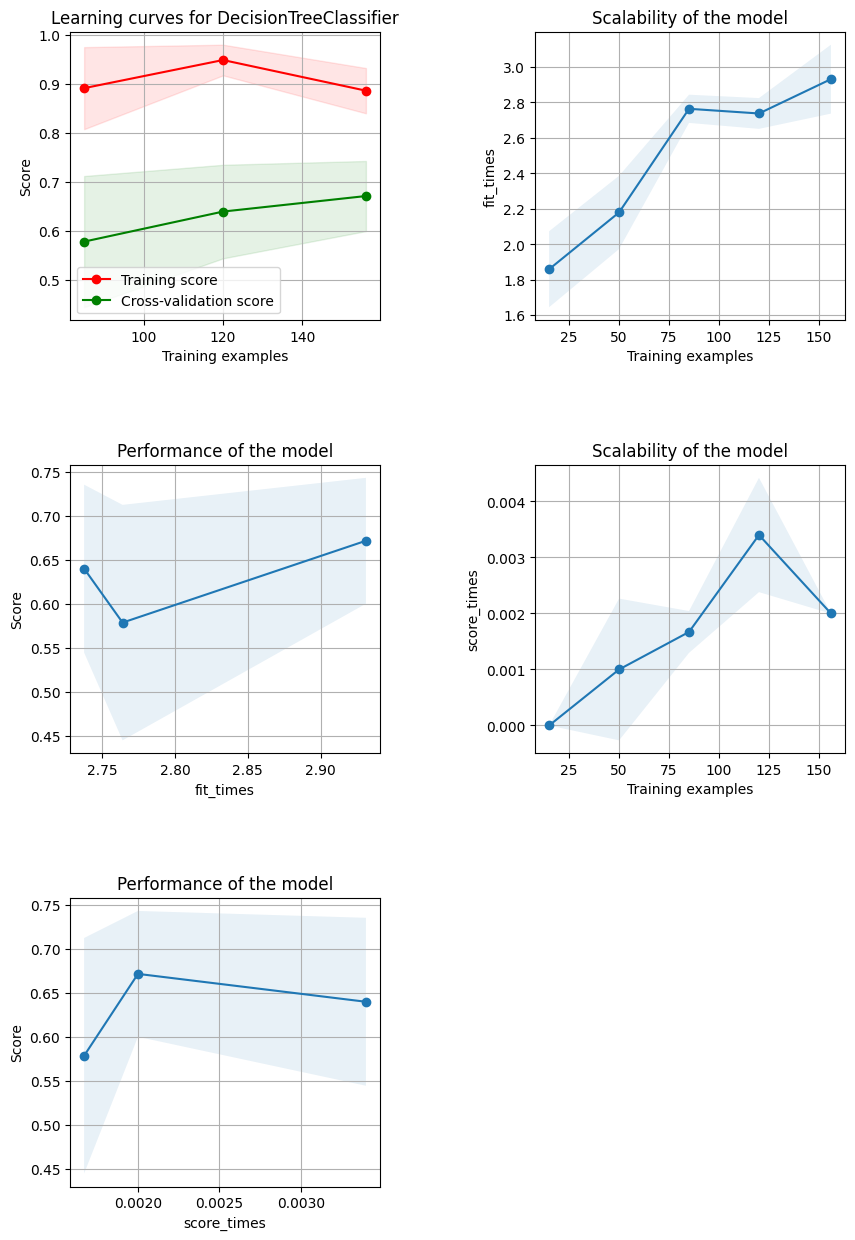

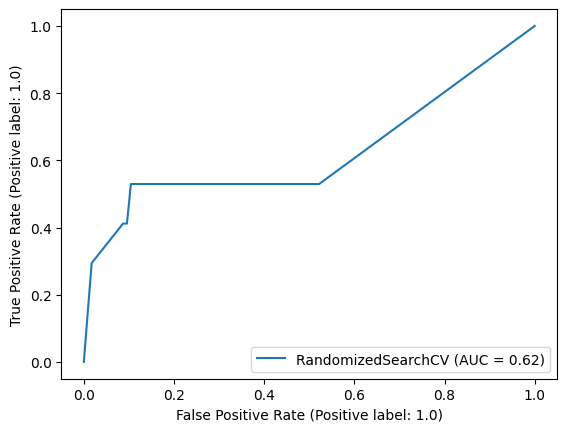

Best params for DecisionTreeClassifier: {'model__splitter': 'best', 'model__min_samples_split': 14, 'model__min_samples_leaf': 4, 'model__max_features': 41, 'model__max_depth': 7, 'model__criterion': 'gini'}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.6214833759590793
Classification report
              precision    recall  f1-score   support

         0.0     0.9266    0.8783    0.9018       115
         1.0     0.3913    0.5294    0.4500        17

    accuracy                         0.8333       132
   macro avg     0.6590    0.7038    0.6759       132
weighted avg     0.8577    0.8333    0.8436       132

Accuracy: 0.8333
AUC: 0.6215
You'd think it's something close to 0.9912790697674421 but it's actually 0.8349279835390948.


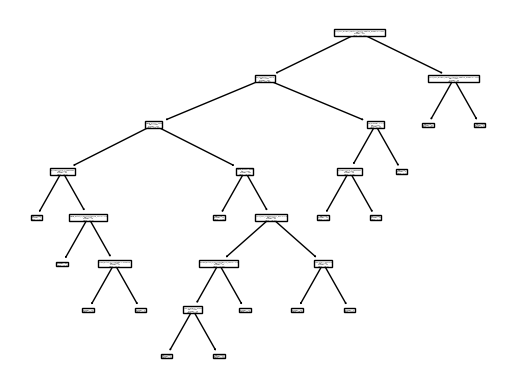

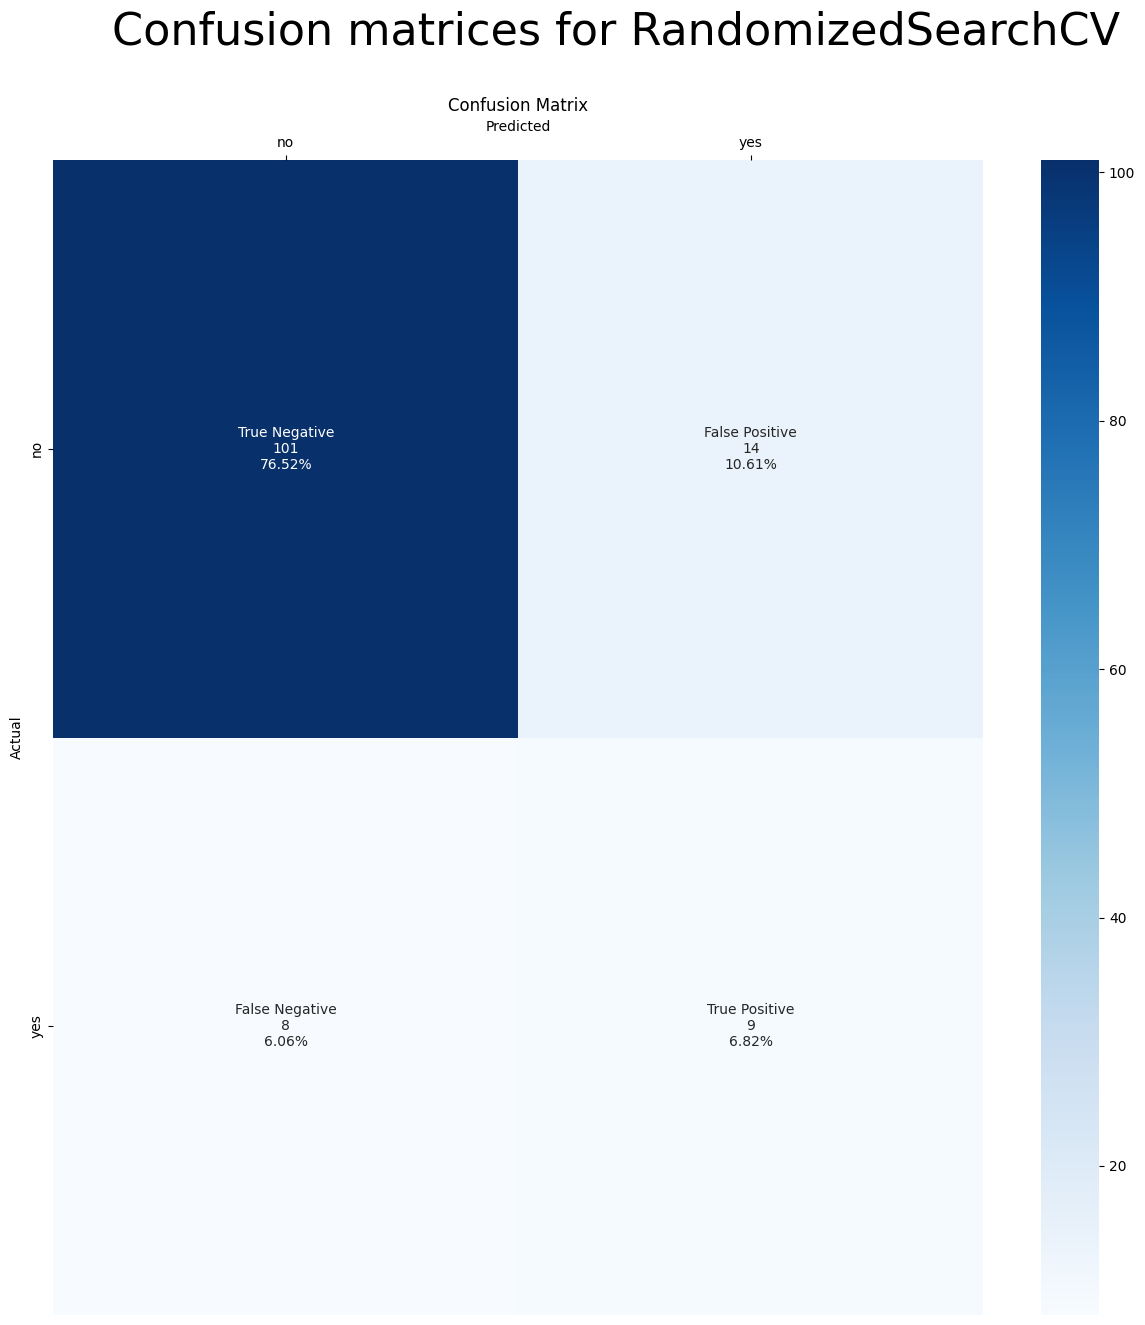

In [31]:
dt = use_model(
    DecisionTreeClassifier(random_state=42), 
    {
        "model__criterion": ['gini', 'entropy'],
        'model__splitter': ['best', 'random'],
        "model__max_depth": range(1, 15),
        'model__max_features': range(1, len(input_cols)),
        "model__min_samples_split": range(2,15),
        "model__min_samples_leaf": range(1,7)
    },
    n_iter=50,
)

In [ ]:
rf = use_model(
    RandomForestClassifier(), 
    { 
        'model__n_estimators': [100, 150],
        'model__max_features': ['sqrt', 'log2'],
        'model__max_depth' : [8,9,10,11,12],
        'model__criterion' :['gini', 'entropy'],
        'model__bootstrap': [True],
        'model__min_samples_leaf': [1,2,3],
        'model__min_samples_split': [2,3],
    },
    n_iter=50,
)

In [ ]:
knn = use_model(
    KNeighborsClassifier(), 
    {
        "n_neighbors": list(range(1,31)),
        "weights": ['uniform', 'distance'],
    }
)

In [ ]:
gnb = use_model(
    GaussianNB(), 
    {
        'var_smoothing': np.logspace(0,-9, num=100)
    }
)

In [ ]:
gb = use_model(
    GradientBoostingClassifier(),
    {
        'max_features': range(7,20,2),
        'min_samples_split':range(1000,2201,400),
        'min_samples_leaf':range(30,71,10),
        'max_depth':range(5,16,2),
        'min_samples_split':range(200,1001,200)
    }
)

In [ ]:
ada = use_model(
    AdaBoostClassifier(),
    {
        'n_estimators': [10,50,100,500],
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]
    }
)

In [ ]:
#from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
xgb = use_model(
    XGBClassifier(use_label_encoder=False, eval_metric='aucpr'),
    {
        'eta': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
        'gamma': [0, 1, 5, 10, 100, 1000],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'min_child_weight': [1, 3, 5, 7],
        'max_delta_step': [0, 0.2, 0.6, 1, 2],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1],
        'sampling_method': ['uniform', 'gradient_based'],
        'scale_pos_weight': [1, 3, 5, 7, 9],
        'max_bin': [16, 32, 64, 128, 256, 512],
    }
)

In [ ]:
lgb = use_model(
    LGBMClassifier(),
    {
        'num_leaves': [31, 63, 127, 255, 511, 1023],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
        'n_estimators': [10, 50, 100, 500, 1000, 2000],
        'subsample_for_bin': [200000, 300000, 400000, 500000],
        'min_child_samples': [20, 30, 40, 50],
    }    
)